In [1]:
import torch
import torch.nn.functional as F
import torch.optim as optim

import torchvision.models as tv_models

import model
import imp
import utility
imp.reload(utility)
from utility import gram_matrix, ImageProcess

In [19]:
debug = True
iter_times = 8000
uniform_h = 200
uniform_w = 200
output_img_path = "./image/cyberpunk_output_img.jpg"
style_img_path = "./image/cyberpunk_img_v1.jpg"
content_img_path = "./image/content_img.jpg"
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

style image shape: torch.Size([1, 3, 1080, 1920])
content image shape: torch.Size([1, 3, 681, 968])


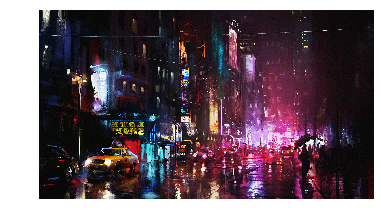

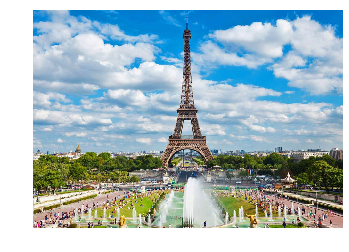

In [20]:
# load image to torchTensor
style_img = ImageProcess.read_image(style_img_path).to(device)
print("style image shape:", style_img.shape)

content_img = ImageProcess.read_image(content_img_path).to(device)
print("content image shape:", content_img.shape)

# paint images
ImageProcess.paint_image(style_img,"style_image")
ImageProcess.paint_image(content_img,"content_image")

In [21]:
# build feature model
vgg16 = tv_models.vgg16(pretrained=True)

In [22]:
vgg16

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (17): Conv2d

In [23]:
vgg16.features

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace)
  (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (17): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(

In [24]:
# convert into self feature extraction model
vgg16 = model.VGG(vgg16.features[:23]).to(device).eval() # notify all layers in eval mode

In [25]:
vgg16

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (17): Conv2d

In [26]:
# get features
style_features = vgg16(style_img)
content_features = vgg16(content_img)
if debug:
    print("style feature:")
    print([i.shape for i in style_features])
    print("content feature:")
    print([i.shape for i in content_features])

style feature:
[torch.Size([1, 64, 1080, 1920]), torch.Size([1, 128, 540, 960]), torch.Size([1, 256, 270, 480]), torch.Size([1, 512, 135, 240])]
content feature:
[torch.Size([1, 64, 681, 968]), torch.Size([1, 128, 340, 484]), torch.Size([1, 256, 170, 242]), torch.Size([1, 512, 85, 121])]


In [27]:
# calculate Gram matrix according to the extracted feature
style_gram = [gram_matrix(i) for i in style_features]
if debug:
    print("style Gram matrix:")
    print([i.shape for i in style_gram])

style Gram matrix:
[torch.Size([1, 64, 64]), torch.Size([1, 128, 128]), torch.Size([1, 256, 256]), torch.Size([1, 512, 512])]


In [28]:
torch.randn(content_img.size()).to(device)

tensor([[[[-0.7097, -0.2598, -0.4886,  ...,  0.0597, -0.2393, -0.9401],
          [-1.0311, -0.4648,  0.1982,  ..., -0.2286,  0.6323,  0.9097],
          [-0.4269, -0.0733,  0.8170,  ..., -1.7244, -0.6077, -0.4095],
          ...,
          [ 0.6899, -1.2679, -0.5123,  ...,  0.7324, -0.2996, -0.7813],
          [-1.2638,  1.1185, -1.7626,  ...,  0.7661,  0.4960,  0.2059],
          [ 0.6445, -0.3439,  0.3095,  ..., -0.3868, -1.0575, -0.0062]],

         [[-0.6176,  0.6057, -0.4660,  ..., -1.0576, -0.9044, -0.0443],
          [-1.4707,  0.3781,  0.8011,  ...,  0.3132, -0.6432,  0.1219],
          [ 0.3309, -1.4557,  0.8538,  ..., -1.9604, -3.1216,  0.3810],
          ...,
          [ 0.0699, -0.3589, -0.1452,  ..., -0.9626,  1.0783,  0.8845],
          [ 0.2582, -0.0106,  1.3859,  ..., -0.7872,  0.5087,  1.0902],
          [ 0.6450, -0.3315, -0.6427,  ...,  1.2037,  0.2037,  0.0449]],

         [[-0.5609,  1.4269,  0.0433,  ...,  1.5353,  0.3436,  0.7218],
          [-0.4456, -1.1739,  

In [39]:
# the stage of train the model
## get the copy of input image as input and set its parameters able to be trained
initial_white_noise = True # 想试试白噪声开始吗？
if initial_white_noise:
    output_img = torch.randn(content_img.size()).to(device)
    output_img.requires_grad_(True)
else:
    output_img = content_img.clone().requires_grad_(True)
optimizer = optim.LBFGS([output_img])

In [40]:
## set hyperparameter
style_weight = 1e6
content_weight = 0.5

In [41]:
## build an list item to be a counter of the closure
it = [0]

Step 0: style_loss: 0.00645 content_loss: 12.48836


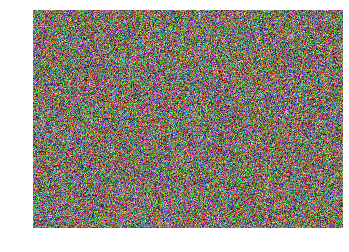

Step 20: style_loss: 0.00003 content_loss: 12.53343
Step 40: style_loss: 0.00001 content_loss: 10.61207
Step 60: style_loss: 0.00001 content_loss: 8.76545
Step 80: style_loss: 0.00001 content_loss: 7.45021
Step 100: style_loss: 0.00000 content_loss: 6.51678


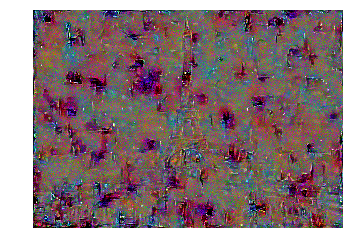

Step 120: style_loss: 0.00000 content_loss: 5.80793
Step 140: style_loss: 0.00000 content_loss: 5.26409
Step 160: style_loss: 0.00000 content_loss: 4.88142
Step 180: style_loss: 0.00000 content_loss: 4.56508
Step 200: style_loss: 0.00000 content_loss: 4.33149


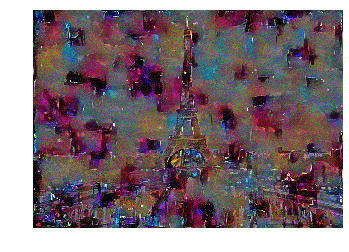

Step 220: style_loss: 0.00000 content_loss: 4.12784
Step 240: style_loss: 0.00000 content_loss: 3.95958
Step 260: style_loss: 0.00000 content_loss: 3.81026
Step 280: style_loss: 0.00000 content_loss: 3.68848
Step 300: style_loss: 0.00000 content_loss: 3.57758


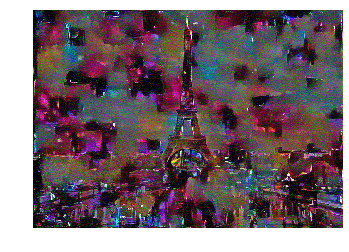

Step 320: style_loss: 0.00000 content_loss: 3.48292
Step 340: style_loss: 0.00000 content_loss: 3.40443
Step 360: style_loss: 0.00000 content_loss: 3.32636
Step 380: style_loss: 0.00000 content_loss: 3.25868
Step 400: style_loss: 0.00000 content_loss: 3.20001


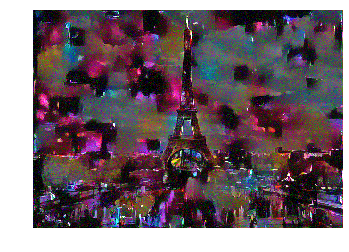

Step 420: style_loss: 0.00000 content_loss: 3.14670
Step 440: style_loss: 0.00000 content_loss: 3.09643
Step 460: style_loss: 0.00000 content_loss: 3.05029
Step 480: style_loss: 0.00000 content_loss: 3.00793
Step 500: style_loss: 0.00000 content_loss: 2.97147


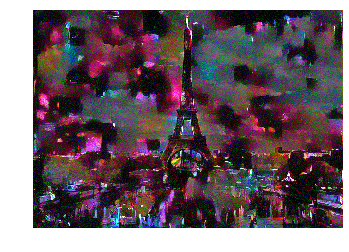

Step 520: style_loss: 0.00000 content_loss: 2.93572
Step 540: style_loss: 0.00000 content_loss: 2.90349
Step 560: style_loss: 0.00000 content_loss: 2.87369
Step 580: style_loss: 0.00000 content_loss: 2.84676
Step 600: style_loss: 0.00000 content_loss: 2.82122


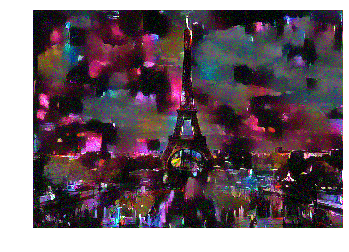

Step 620: style_loss: 0.00000 content_loss: 2.79729
Step 640: style_loss: 0.00000 content_loss: 2.77592
Step 660: style_loss: 0.00000 content_loss: 2.75409
Step 680: style_loss: 0.00000 content_loss: 2.73466
Step 700: style_loss: 0.00000 content_loss: 2.71582


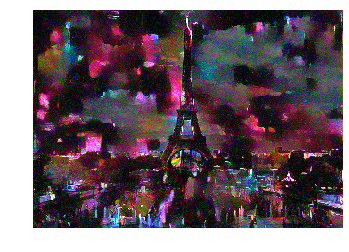

Step 720: style_loss: 0.00000 content_loss: 2.69932
Step 740: style_loss: 0.00000 content_loss: 2.68352
Step 760: style_loss: 0.00000 content_loss: 2.66873
Step 780: style_loss: 0.00000 content_loss: 2.65526
Step 800: style_loss: 0.00000 content_loss: 2.64188


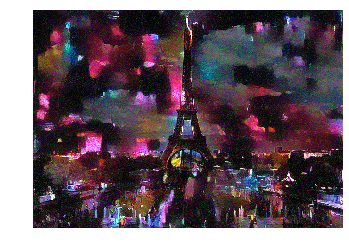

Step 820: style_loss: 0.00000 content_loss: 2.62923
Step 840: style_loss: 0.00000 content_loss: 2.61829
Step 860: style_loss: 0.00000 content_loss: 2.60678
Step 880: style_loss: 0.00000 content_loss: 2.59666
Step 900: style_loss: 0.00000 content_loss: 2.58713


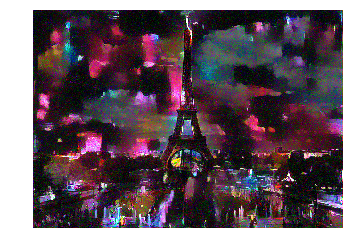

Step 920: style_loss: 0.00000 content_loss: 2.57775
Step 940: style_loss: 0.00000 content_loss: 2.56910
Step 960: style_loss: 0.00000 content_loss: 2.56098
Step 980: style_loss: 0.00000 content_loss: 2.55280
Step 1000: style_loss: 0.00000 content_loss: 2.54518


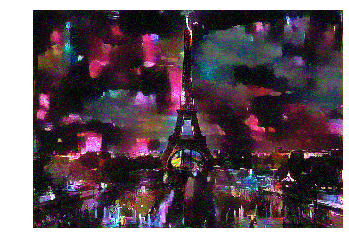

Step 1020: style_loss: 0.00000 content_loss: 2.53730
Step 1040: style_loss: 0.00000 content_loss: 2.52996
Step 1060: style_loss: 0.00000 content_loss: 2.52323
Step 1080: style_loss: 0.00000 content_loss: 2.51691
Step 1100: style_loss: 0.00000 content_loss: 2.51078


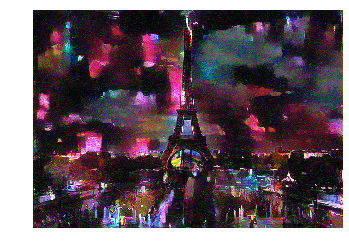

Step 1120: style_loss: 0.00000 content_loss: 2.50543
Step 1140: style_loss: 0.00000 content_loss: 2.50034
Step 1160: style_loss: 0.00000 content_loss: 2.49532
Step 1180: style_loss: 0.00000 content_loss: 2.49051
Step 1200: style_loss: 0.00000 content_loss: 2.48611


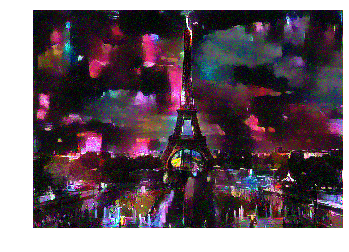

Step 1220: style_loss: 0.00000 content_loss: 2.48158


KeyboardInterrupt: 

In [42]:
## train the model
while it[0] < iter_times:

    def closure():
        optimizer.zero_grad() # TODO
        output_features = vgg16(output_img)

        # summarize the loss between output_img and style_img, content_img
        content_loss = F.mse_loss(input=output_features[2], target=content_features[2])
        style_loss = 0
        output_gram = [gram_matrix(i) for i in output_features]
        for og, sg in zip(output_gram, style_gram):
            style_loss += F.mse_loss(input=og, target=sg)
        # factors of the tradeoff between style_loss and content_loss is hyperparameters
        loss = style_loss * style_weight + content_loss * content_weight

        if it[0] % 20 == 0:
            print("Step %d: style_loss: %.5f content_loss: %.5f" % (it[0], style_loss, content_loss))
        if it[0] % 100 == 0:
            ImageProcess.paint_image(output_img, title='Output Image')

        # calculate gradient through backward
        loss.backward()
        it[0] += 1

        return loss

    # LBFGS optimizer to update parameters needs a closure that reevaluates the model and returns the loss
    optimizer.step(closure)

In [43]:
temp_output_img = output_img.clone()

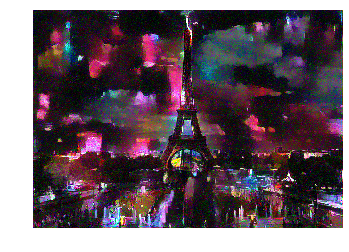

Successfully save the final stylized image to: ./image/cyberpunk_output_img.jpg


In [44]:
ImageProcess.paint_image(output_img, title='Output Image')
ImageProcess.save_image(output_img, output_img_path)